In [1]:
import os
import numpy as np
import json
from detectron2.data import DatasetCatalog, MetadataCatalog
from data import datasets

dir = 'dataset/composite/'
quick_draw_dataset = datasets.QuickDrawDataset()
classes = list(quick_draw_dataset.labels_to_indices.keys())

def get_dataset(mode):
    filename = os.path.join(dir, mode + '/data.json')
    with open(filename) as f:
        return json.load(f)

for d in ["train", "val", "test"]:
    DatasetCatalog.register("composite_" + d, lambda d=d: get_dataset(d))
    MetadataCatalog.get("composite_" + d).set(thing_classes=classes)
composite_metadata = MetadataCatalog.get("composite_train")

%load_ext autoreload
%autoreload 2

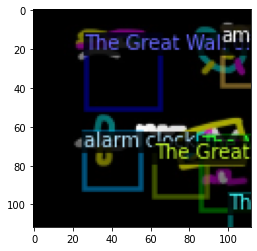

In [2]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get("composite_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=composite_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import torch

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("composite_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.NUM_CLASSES = len(classes)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()